In [5]:
from matplotlib import pyplot 
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    data = pyplot.imread(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels) 
    # extract the bounding box from the first face
    #print(results)
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x2, y2 = x1 + width, y1 + height
        pyplot.subplot(1, len(results), i+1)
        #face = pixels[y1:y2, x1:x2]
        #print(len(results))
        pyplot.axis('off')
        pyplot.imshow(pixels[y1:y2, x1:x2])
        #face = pixels[y1:y2, x1:x2]
        # resize pixels to the model size
        #image = Image.fromarray(face)
        #image = image.resize(required_size)
        #face_array = np.asarray(image)
        #i=i+1
        #return pixels[y1:y2, x1:x2]
        

# load the photo and extract the face


#plt.imshow(pixels)
#plt.show()
#print(pixels.shape)


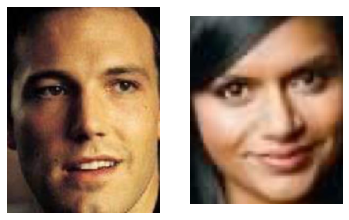

In [6]:
extract_face('t.jpg')

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

In [8]:
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [9]:
faceemd = np.load('5-celebrity-faces-embeddings.npz')
emdTrainX, trainy, emdTestX, testy = faceemd['arr_0'], faceemd['arr_1'], faceemd['arr_2'], faceemd['arr_3']
print('Loaded: ', emdTrainX.shape, trainy.shape, emdTestX.shape, testy.shape)

Loaded:  (93, 128) (93,) (25, 128) (25,)


In [10]:
from tensorflow.keras.models import load_model
import tensorflow as tf
# load the facenet model
facenet_model = load_model('./facenet_keras.h5')
print('Loaded Model')

Loaded Model


In [15]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

(93, 128)
(25, 128)


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
#print(emdTestX_norm)
#print(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[87.28653075  3.54014885  1.54665296  3.68119329  3.94547415]
Expected: ben_afflek


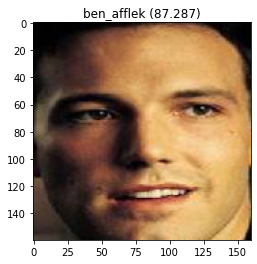

In [82]:
random_face = testX[0]
random_face_emd = emdTestX_norm[0]
random_face_class = testy_enc[0]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

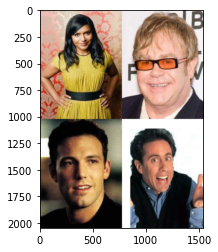

In [12]:
image = Image.open('test.jpg')
plt.imshow(image)
plt.show

In [17]:
image = Image.open('test.jpg')
image = image.convert('RGB')
pixels = np.asarray(image)


detector = MTCNN()
results = detector.detect_faces(pixels) 

x1, y1, width, height = results[0]['box']
x2, y2 = x1 + width, y1 + height
face = pixels[y1:y2, x1:x2]
emdTest = list()
em = get_embedding(facenet_model, face)
emdTest.append(em)
emdTest = np.asarray(emdTest)

emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)

emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)


in_encoder = Normalizer()
emdTest_norm = in_encoder.transform(emdTest)
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTest_norm)
face_emd = emdTest_norm[0]
sample = np.expand_dims(face_emd, axis=0)
yhat_c = model.predict(sample)
yhat_p = model.predict_proba(sample)
class_in = yhat_c[0]
class_prob = yhat_p[0,class_in] * 100
predict_name = out_encoder.inverse_transform(yhat_c)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
print('Predicted: \n%s \n%s' % (all_names, yhat_p[0]*100))
print('Expected: %s' % predict_name)

Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[10.17384802 46.48465907  3.89172377 28.59986773 10.84990142]
Expected: ['elton_john']
